In [1]:
import torch
import torch.nn as nn
import random
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set all random seeds for reproducibility
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Data augmentation
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # keep 1 channel
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # simple normalization for 1 channel
])

# Preprocessing for validation and test images (no augmentation)
test_val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_data = datasets.ImageFolder(
    "synapse_patches_256/train",
    transform=train_transform
)

val_data = datasets.ImageFolder(
    "synapse_patches_256/val",
    transform=test_val_transform
)

test_data = datasets.ImageFolder(
    "synapse_patches_256/test",
    transform=test_val_transform
)

# Print dataset information
print("Train samples:", len(train_data))
print("Val samples:", len(val_data))
print("Test samples:", len(test_data))

# Prints class name
print(train_data.class_to_idx)


Train samples: 3001
Val samples: 450
Test samples: 450
{'excitatory': 0, 'inhibitory': 1}


In [2]:
import torch.nn.functional as F


class BaselineCNN128(nn.Module):
    def __init__(self):
        super().__init__()

        # Will be used to set the fully connected layer size dynamically
        self.flattened_size = None  # we will set this later
        
        # ---- Block 1 ----
        # Input: 1 × 128 × 128  →  Output: 32 × 128 × 128
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        # ---- Block 2 ----
        # Input: 32 × 64 × 64  →  Output: 64 × 64 × 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        # ---- Block 3 ----
        # Input: 64 × 32 × 32 → Output: 128 × 32 × 32
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        # ---- Block 4 ----
        # Input: 128 × 16 × 16 → Output: 256 × 16 × 16
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)

        # ---- Classification Head ----
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 8 * 8, 256)  # after 4 maxpools: 128→64→32→16→8
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        # flatten
        x = x.view(x.size(0), -1)

        # dynamically create fc1 if not done yet
        if self.flattened_size is None:
            self.flattened_size = x.size(1)
            self.fc1 = nn.Linear(self.flattened_size, 256).to(x.device)

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class BaselineCNN256(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution blocks
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)

        # NEW: updated size for 256x256 input
        # 256 → 128 → 64 → 32 → 16
        self.fc1 = nn.Linear(256 * 16 * 16, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        # Flatten
        x = x.view(x.size(0), -1)

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [3]:
# Instantiate model
model = BaselineCNN256()

# Training hyperparameters.
learning_rate = 0.00025
epochs = 30
batchsize = 32

# Cross-entropy loss
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Select GPU if available, otherwise fall back to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.cuda()

BaselineCNN256(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=65536, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [4]:
# Initialize a random number generator for deterministic data loading order
g = torch.Generator()
g.manual_seed(seed)

# DataLoader for training set
# - Uses shuffling for stochastic training
# - `generator=g` ensures deterministic shuffling when using a fixed seed
# - `num_workers=2` enables parallel data loading for improved performance
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, generator=g, num_workers=2)
val_loader   = DataLoader(val_data, batch_size=batchsize, shuffle=False, num_workers=2,)
test_loader  = DataLoader(test_data, batch_size=batchsize, shuffle=False, num_workers=2,)


In [5]:
# For tracking loss and accuracy
train_loss_list = []
val_accuracies = []


In [6]:
for epoch in range(epochs):
    model.train()    # Set model to training mode
    total_loss = 0.0 # Track cumulative loss for the epoch
    
    # Training Loop (iterate over mini-batches)
    for batch_idx, (train_input, train_target) in enumerate(train_loader):

        optimizer.zero_grad() # Reset gradients from previous step
        pred = model(train_input.cuda())  # Forward pass
        loss = loss_func(pred, train_target.cuda())  # Compute loss

        loss.backward() # Backpropagation
        optimizer.step() # Update model parameters

        total_loss += loss.item() # Accumulate loss for averaging

    # Compute mean loss across all mini-batches for this epoch
    avg_loss = total_loss / len(train_loader)
    train_loss_list.append(avg_loss)

    # ---------------------------------------
    # Validation
    # ---------------------------------------
    correct, total = 0, 0
    model.eval()

    with torch.no_grad():
        for val_input, val_target in val_loader:
            val_input, val_target = val_input.cuda(), val_target.cuda()

            pred = model(val_input)
            _, predicted = torch.max(pred, 1)

            total += val_target.size(0)
            correct += (predicted == val_target).sum().item()

    # Calculate validation accuracy
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)

    # Logging
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch 1/30 - Loss: 1.1856, Val Accuracy: 51.56%
Epoch 2/30 - Loss: 0.7585, Val Accuracy: 50.44%
Epoch 3/30 - Loss: 0.7434, Val Accuracy: 52.00%
Epoch 4/30 - Loss: 0.7171, Val Accuracy: 50.22%
Epoch 5/30 - Loss: 0.7052, Val Accuracy: 50.89%
Epoch 6/30 - Loss: 0.7031, Val Accuracy: 51.33%
Epoch 7/30 - Loss: 0.6823, Val Accuracy: 51.33%
Epoch 8/30 - Loss: 0.6703, Val Accuracy: 50.89%
Epoch 9/30 - Loss: 0.6716, Val Accuracy: 53.11%
Epoch 10/30 - Loss: 0.6669, Val Accuracy: 50.67%
Epoch 11/30 - Loss: 0.6600, Val Accuracy: 54.67%
Epoch 12/30 - Loss: 0.6597, Val Accuracy: 52.44%
Epoch 13/30 - Loss: 0.6553, Val Accuracy: 50.67%
Epoch 14/30 - Loss: 0.6547, Val Accuracy: 51.56%
Epoch 15/30 - Loss: 0.6519, Val Accuracy: 50.89%
Epoch 16/30 - Loss: 0.6448, Val Accuracy: 51.78%
Epoch 17/30 - Loss: 0.6461, Val Accuracy: 52.44%
Epoch 18/30 - Loss: 0.6365, Val Accuracy: 54.89%
Epoch 19/30 - Loss: 0.6293, Val Accuracy: 50.67%
Epoch 20/30 - Loss: 0.6250, Val Accuracy: 53.11%
Epoch 21/30 - Loss: 0.6329, V

In [7]:
# Save trained model weights
save_path = "synapse_cnn_bs32_30_D256.pth"
torch.save(model.state_dict(), save_path)
print("Model saved to:", save_path)


Model saved to: synapse_cnn_bs32_30_D256.pth


In [8]:
# UNCOMMENT IF YOU WANT TO LOAD SAVED MODEL
# load_path = "/content/drive/MyDrive/synapse_resnet.pth"

# model = BaselineCNN()

# model.load_state_dict(torch.load(load_path, map_location=device))
# model.to(device)
# model.eval()

# print("Model loaded from:", load_path)

In [9]:
# Testing
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for test_input, test_target in test_loader:
        test_input, test_target = test_input.to(device), test_target.to(device)

        pred = model(test_input)
        _, predicted = torch.max(pred, 1)

        total += test_target.size(0)
        correct += (predicted == test_target).sum().item()
        
# Compute final test accuracy
test_acc = 100 * correct / total
print(f"TEST ACCURACY: {test_acc:.2f}%")


TEST ACCURACY: 63.56%


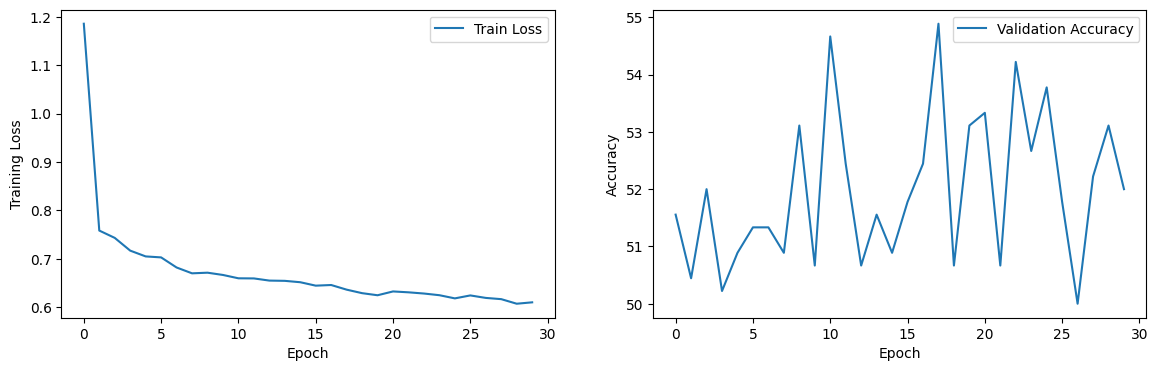

In [10]:
import matplotlib.pyplot as plt

# Plot train loss and validation accuracy
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(train_loss_list, label='Train Loss')
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend()


plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Confusion Matrix:
[[130  95]
 [ 69 156]]


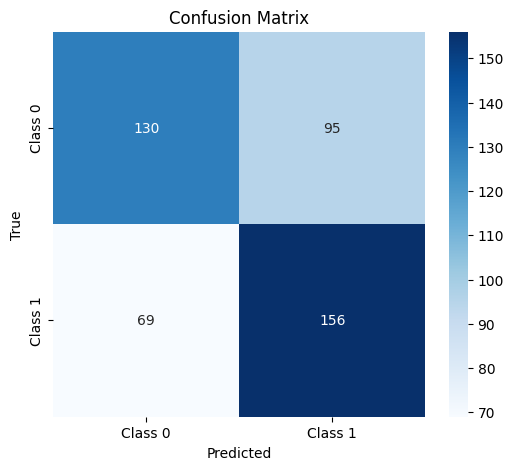


Accuracy:  0.6356
Precision: 0.6374
Recall:    0.6356
F1-Score:  0.6343

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.58      0.61       225
           1       0.62      0.69      0.66       225

    accuracy                           0.64       450
   macro avg       0.64      0.64      0.63       450
weighted avg       0.64      0.64      0.63       450



In [11]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Collect all predictions and targets
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for test_input, test_target in test_loader:
        test_input, test_target = test_input.to(device), test_target.to(device)

        outputs = model(test_input)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(test_target.cpu().numpy())

# Convert to NumPy
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(cm)

# Visual Plot of Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Class 0', 'Class 1'],
    yticklabels=['Class 0', 'Class 1']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
acc = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

print(f"\nAccuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(all_targets, all_preds, zero_division=0))
